In [1]:
import os
import pickle
import datetime
import warnings

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
import madmom

from segment import segment_spectrogram
from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor, cnn_normalize
from datasets import Dataset
from analyze_detection import evaluate, f_score
from models.bock2013pret import get_model

%load_ext autoreload
%autoreload 2

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

SR = 44100
FPS = 100
CONTEXT = 7

In [2]:
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds2 = Dataset("slurtest_add_2")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")


Some sample rates are not equal to 44.1kHz!
Some sample rates are not equal to 44.1kHz!


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [3]:
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [ ]:
[print("Name of rec: {}\n"
       "Len in seconds: {:.2f}\n"
       "Shape of audio: {}\n"
       "Shape of onset schedule: {}\n"
       "Onsets from {:.2f}s to {:.2f}s\n".format(
                                        os.path.split(fname)[1], 
                                        audio.shape[0]/sr,
                                        audio.shape,
                                        schedule.shape,
                                        schedule.min(),
                                        schedule.max(),
                                        ) 
    ) for fname, audio, schedule, sr in zip(audio_fnames, audios, onset_schedules, sample_rates)
]

In [ ]:
# Add white noise to recordings
# Noise variance is adjusted to a fixed Signal Noise Ratio computed recording-wise
# snr_db = 20 means S/N=10
# snr_db = 10 means S/N≈3.2
SNR_DB = 10
snr_v = 10**(SNR_DB/20)

def augmentation(audio, t=None, p=None):
    if t==None:
        return audio
    elif t=="white_noise":
        # p contains snr_db parameter
        return audio+np.random.normal(
            scale=madmom.audio.signal.root_mean_square(audio)/(10**(p/20)),
            size=audio.shape
            )

for audio, fname in zip(audios, audio_fnames):
    np.save("dataset/augmented/" + os.path.basename(fname) + "_noise_SNRdB_"+SNR_DB)


In [4]:
onset_vectors = [get_label_vector(sched, len(audio)/sr, FPS)
    for (sched, audio, sr) in zip(onset_schedules, audios, sample_rates)
]

In [5]:
# Create data and normalize
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]
print(mm_frames_normalized[0].shape)
#X = [[
#    data[i-CONTEXT:i+CONTEXT+1,:,:] 
#    for i in range(CONTEXT, data.shape[0]-CONTEXT)
#] for data in mm_frames_normalized]
#X = [np.transpose(np.stack(data, 0), [0,2,1,3]) for data in X]
#print(X[0].sum())

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


(1711, 80, 3)


In [6]:
def data_generator(
    batch_size,
    steps_per_epoch,
    epochs,
    idx, 
    sampling=True,
    mode=None,
    standard=False,
    mean=None,
    std=None
):
    
    #for _ in range(steps_per_epoch * epochs):
    if not sampling:
        ep = 0
        file_p = 0
        frame_p = 0
    
    while True:
        # Select indices for training or test
        if sampling:
            file_i = np.random.choice(idx)
        else:
            file_i = idx[file_p]
        
        #print("Selected file index: ", file_i)
        fname = audio_fnames[file_i]
        
        if mode=="use_prep_frames":
            frames = mm_frames_normalized[file_i]
        elif mode=="use_raw_frames":
            # No normalization
            frames = mm_proc_frames[file_i]    
        else:
            # Compute frames
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fxn()
                frames = cnn_normalize(preprocessor(fname))

        if standard:
            frames = (frames-mean)/std
            
        #print("Frame size: ", frames.shape[0])

        # Retrieve onsets 
        onsets = onset_vectors[file_i]
        #print("Computed frames of size ", frames.shape)
        #print("Onset vectors have len ", len(onsets))

        # Sample a set of indices (defined from audio start,
        # that is CONTEXT values counted from x array start)
        if sampling:
            focus_idx = np.random.choice(
                np.arange(frames.shape[0]-2*CONTEXT-1), 
                size=batch_size
            )
            #print("Sampled focus idx between ", 0, " and ", frames.shape[0]-2*CONTEXT-1)
        else:
            #print("Focus idx from ", frame_p, " to ", frame_p+batch_size)
            focus_idx = np.arange(frame_p, frame_p+batch_size)
        

        # Segmentation
        x = [frames[focus:focus+2*CONTEXT+1,:,:] for focus in focus_idx]
        x = np.transpose(np.stack(x, 0), [0,2,1,3])
        #print("Segmented x has shape ", x.shape)
        if x.shape[0] != batch_size:
            print("Delivering less than batch-size")

        # Labels
        y = onsets[focus_idx]
        yield (x, y)

        if not sampling:
            if frame_p + 2*batch_size >= frames.shape[0]-2*CONTEXT-1:
                if file_p == len(idx) - 1:
                    ep += 1
                    print("Generator reached end of epoch. Resetting...")
                    file_p = 0
                    frame_p = 0
                else:
                    file_p += 1
                    frame_p = 0
            else:
                frame_p += batch_size
            



In [12]:
# Custom split:
n_splits = 1
kf_gen = [[np.arange(19), np.arange(19, len(audio_fnames))]]

In [8]:
# K-Fold:


random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = list(kf.split(np.arange(len(audio_fnames))))

In [8]:
# Precompute statistics
means_per_fold = []
std_per_fold = []
for train_idx, test_idx in kf_gen:
    train_frames = np.concatenate([mm_proc_frames[i] for i in train_idx]) 
    mean_train = train_frames.mean(0).reshape((80,1,3))
    std_train = train_frames.std(0, ddof=1).reshape((80,1,3))
    means_per_fold.append(mean_train)
    std_per_fold.append(std_train)

with open('results/computed/added_means_by_fold.pickle', 'wb') as file_pi:
    pickle.dump(means_per_fold, file_pi)
with open('results/computed/added_std_by_fold.pickle', 'wb') as file_pi:
    pickle.dump(std_per_fold, file_pi)



In [8]:
def compute_steps(idx, bs):
    song_sizes = np.array([len(f) for f in mm_frames_normalized])[idx]-2*CONTEXT-1
    steps_per_song = np.floor_divide(song_sizes, bs)
    return np.sum(steps_per_song)

In [9]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    #tf.keras.metrics.TruePositives(name='tp', thresholds=0.5),
    #tf.keras.metrics.TrueNegatives(name='tn', thresholds=0.5),
    #tf.keras.metrics.FalsePositives(name='fp', thresholds=0.5),
    #tf.keras.metrics.FalseNegatives(name='fn', thresholds=0.5),
]

In [10]:
datasets = "a"
continue_run = False
training_mode = "all" # REMEMBER TO CHANGE
check_at_epoch = 5 

save = True # REMEMBER TO CHANGE
 # REMEMBER TO CHANGE
save_path = "results/cnn-training-220425/" # TODO - automatically
n_epochs = 35 # REMEMBER TO CHANGE
learning_r = 0.001
bs = 256
steps_per_epoch = int(np.sum(np.array([len(f) for f in mm_frames_normalized])[kf_gen[0][0]]-2*CONTEXT-1)/bs)
val_steps_per_epoch = 30
nogen = False
sampling = False

standard = False # keep in mind on which data format statistics are computed 
mode = 'use_prep_frames' # Preparing by BN layer/"CNN normalization"
#mode = 'use_raw_frames' # No preparing


training_name = "{}-{}-{}eps-lr{:.4f}-{}".format(
    datasets, 
    "nogen" if nogen else ("sample" if sampling else "seq"),
    n_epochs,
    learning_r,
    "standard" if standard else "nostandard"
)


In [13]:
if standard:
    with open('results/computed/added_means_by_fold.pickle', 'rb') as file_pi:
        means = pickle.load(file_pi)
    with open('results/computed/added_std_by_fold.pickle', 'rb') as file_pi:
        stds = pickle.load(file_pi)

if isinstance(training_mode, int):
    fold = training_mode
else:
    fold = 0

while fold < n_splits:
    print()
    print("Fold {}/{} ---------".format(fold, n_splits))
    train_idx = kf_gen[fold][0]
    test_idx = kf_gen[fold][1]
    print("Train indices: ", train_idx)
    print("Test indices: ", test_idx)

    # Data
    if nogen:
        X_train, X_test = [
            np.concatenate([X[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]
        y_train, y_test = [
            np.concatenate([onset_vectors[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]

    #train_onset_ratio = y_train.sum()/len(y_train)

    # Normalize with training set statistics
    if standard:
        mean = means[fold]
        std = stds[fold]
    else:
        mean, std = None, None

    # Model
    if not continue_run:
        tf.keras.backend.clear_session()
    (model, norm_layer)=get_model(finetune=False)
    model.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=metrics)
                
    if not sampling:
        steps_per_epoch = compute_steps(train_idx, bs)
        val_steps_per_epoch = compute_steps(test_idx, bs)

    if nogen:
        x = X_train
        y = y_train
        steps_per_epoch = None
        validation_data = (X_test, y_test)
    else:
        x = data_generator(
            batch_size=bs, 
            steps_per_epoch=steps_per_epoch, 
            epochs=n_epochs,
            idx=train_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
        )
        y = None
        validation_data = data_generator(
            batch_size=bs, 
            steps_per_epoch=val_steps_per_epoch, 
            epochs=n_epochs,
            idx=test_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
        )

    checkpoint_path = save_path + 'fold_{}_{}'.format(fold,training_name)+"_cp_{epoch:04d}.ckpt"
    if check_at_epoch is None:
        cp_callback=[]
    else:
        cp_callback = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                    save_weights_only=True,
                                                    save_freq=int(steps_per_epoch*check_at_epoch))]
    # Training
    
    history = model.fit(
        x = x, y = y, 
        steps_per_epoch = steps_per_epoch,
        epochs          = n_epochs,
        # Validation data
        validation_data = validation_data,
        validation_steps  = val_steps_per_epoch,
        class_weight = {0: 1., 1: 1/0.035},
        callbacks=cp_callback,
        verbose=1
    )

    # Saving
    if save:
        model.save(save_path + 'fold_{}_{}_model'.format(fold, training_name))
        with open(save_path + 'fold_{}_{}_history.pickle'.format(fold, training_name), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    
    
    if training_mode != "all":
        break
    fold += 1
    


Fold 0/1 ---------
Train indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Test indices:  [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
Epoch 1/50


2022-04-25 15:25:09.403845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 15:25:09.408257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 15:25:09.408561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 15:25:09.409321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

274/274 [==============================] - 11s 35ms/step - loss: 0.7231 - val_loss: 0.3154
Epoch 2/50
274/274 [==============================] - 10s 35ms/step - loss: 0.5810 - val_loss: 0.2723
Epoch 3/50
274/274 [==============================] - 10s 35ms/step - loss: 0.5632 - val_loss: 0.2948
Epoch 4/50
274/274 [==============================] - 10s 35ms/step - loss: 0.5413 - val_loss: 0.2676
Epoch 5/50
274/274 [==============================] - 10s 35ms/step - loss: 0.5145 - val_loss: 0.2594
Epoch 6/50
274/274 [==============================] - 10s 35ms/step - loss: 0.5026 - val_loss: 0.2509
Epoch 7/50
274/274 [==============================] - 10s 35ms/step - loss: 0.4932 - val_loss: 0.2621
Epoch 8/50
274/274 [==============================] - 9s 34ms/step - loss: 0.4838 - val_loss: 0.2291
Epoch 9/50
274/274 [==============================] - 10s 35ms/step - loss: 0.4593 - val_loss: 0.2252
Epoch 10/50
274/274 [==============================] - 10s 35ms/step - loss: 0.4598 - val_loss

2022-04-25 15:33:17.519999: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: results/cnn-training-220425/fold_0_a-seq-50eps-lr0.0010-nostandard_model/assets


INFO:tensorflow:Assets written to: results/cnn-training-220425/fold_0_a-seq-50eps-lr0.0010-nostandard_model/assets


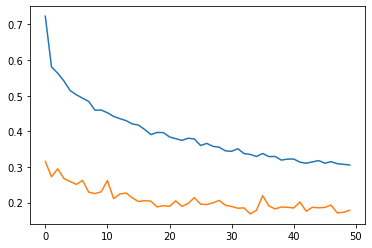

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [16]:
from modules.analysis_funcs import get_segmented_data, get_test_peaks
import mir_eval

TOL = 0.025

CD_list = []
FN_list = []
FP_list = []

fold = kf_gen[0]
test_idx = fold[1]
fold_average = []
for r in test_idx:
    rec_name = os.path.basename(audio_fnames[r])
    sig = madmom.audio.Signal(audio_fnames[r])
    x = get_segmented_data(audio_fnames[r])
    out = model.predict(x)
    peaks = get_test_peaks(out, 1./FPS)
    
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
    CD_list.append(CD)
    FN_list.append(FN)
    FP_list.append(FP)
    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    print(rec_name + "\t" + "F-score: {:.2f}".format(100*scores["F-measure"]))
    fold_average.append(scores["F-measure"])
print("Average F-score {:.2f}".format(fold, 100*np.mean(fold_average)))
print("Total (weighted) F-score: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list)))))

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


stormhatten_IR2.wav	F-score: 83.60
slurtest02_IR1.wav	F-score: 91.73
slurtest01_IR2.wav	F-score: 89.55
slurtest03_FK1.wav	F-score: 90.23
6xtpsg_220319.wav	F-score: 80.65
slurtest04_IR2.wav	F-score: 92.31
melodyvib_220319.wav	F-score: 61.70
slurtest09_IR2.wav	F-score: 87.07
janissa_IR2.wav	F-score: 74.42
6xtpsg_220306.wav	F-score: 76.24
slurtest01_FK1.wav	F-score: 86.36


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest04_FK1.wav	F-score: 92.31
slurtest01_IR1.wav	F-score: 90.62
63an_start_220306.wav	F-score: 83.53
slurtest08_FK1.wav	F-score: 98.95


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest03_IR1.wav	F-score: 86.52
stormhatten_IR1.wav	F-score: 87.87
Fold [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])]    average F-score 85.51
Total (weighted) F-score:  85.12


In [24]:

scoress = []
for r in test_idx:
    scores = []
    rec_name = os.path.basename(audio_fnames[r])
    print(rec_name)
    sig = madmom.audio.Signal(audio_fnames[r])
    x = get_segmented_data(audio_fnames[r])
    for epoch in epoch_checks:
        model.load_weights(checkpoint_path.format(epoch=epoch))
        out = model.predict(x)
        peaks = get_test_peaks(out, 1./FPS)
        s = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        scores.append(s["F-measure"])
    scoress.append(scores)

stormhatten_IR2.wav
slurtest02_IR1.wav
slurtest01_IR2.wav
slurtest03_FK1.wav
6xtpsg_220319.wav
slurtest04_IR2.wav
melodyvib_220319.wav
slurtest09_IR2.wav
janissa_IR2.wav
6xtpsg_220306.wav
slurtest01_FK1.wav
slurtest04_FK1.wav


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest01_IR1.wav
63an_start_220306.wav
slurtest08_FK1.wav
slurtest03_IR1.wav


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


stormhatten_IR1.wav


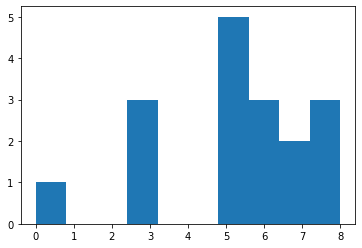

<BarContainer object of 10 artists>

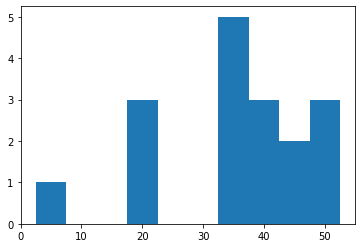

In [37]:
epoch_checks = np.arange(check_at_epoch, n_epochs+check_at_epoch, check_at_epoch)
n, bins, _ = plt.hist(np.argmax(np.array(scoress), axis=1))
plt.show()
plt.bar(epoch_checks, n, width=5.0)

In [15]:
with open("results/cnn-training-220409/fold_0_added-sample-gen-nostandard_history.pickle", 'rb') as file_pi:
    h_samp = pickle.load(file_pi)
with open("results/cnn-training-220409/fold_0_added-seq-gen-nostandard_history.pickle", 'rb') as file_pi:
    h_seq = pickle.load(file_pi)


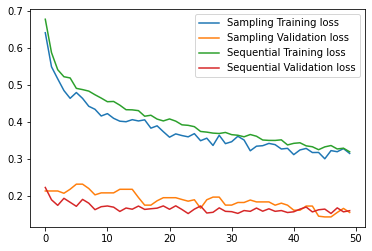

In [16]:
from scipy.signal import medfilt
samp_val_smooth = medfilt(h_samp["val_loss"], 3)

plt.plot(h_samp['loss'], "-")
#plt.plot(h_samp['val_loss'], "-")
plt.plot(samp_val_smooth, "-")
plt.plot(h_seq['loss'], "-")
plt.plot(h_seq['val_loss'], "-")
plt.legend([
    "Sampling Training loss", 
    "Sampling Validation loss",
    "Sequential Training loss", 
    "Sequential Validation loss",
])

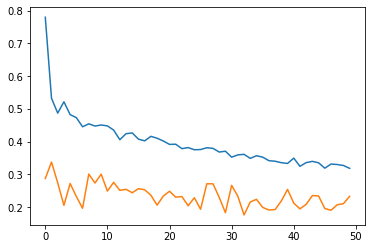

In [21]:
fold = "4"
with open("results/cnn-training-220409/fold_"+fold+"_added-sample-gen-nostandard_history.pickle", 'rb') as file_pi:
    h = pickle.load(file_pi)
plt.plot(h['loss'], "-")
plt.plot(h['val_loss'], "-")

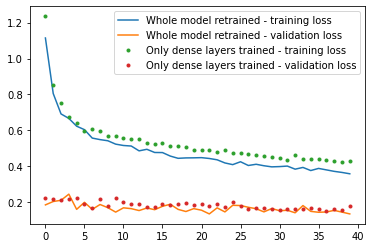

In [93]:
plt.plot(h_all['loss'], "-")
plt.plot(h_all['val_loss'], "-")
plt.plot(h_dense['loss'], ".")
plt.plot(h_dense['val_loss'], ".")
plt.legend([
    "Whole model retrained - training loss", 
    "Whole model retrained - validation loss",
    "Only dense layers trained - training loss", 
    "Only dense layers trained - validation loss",
])

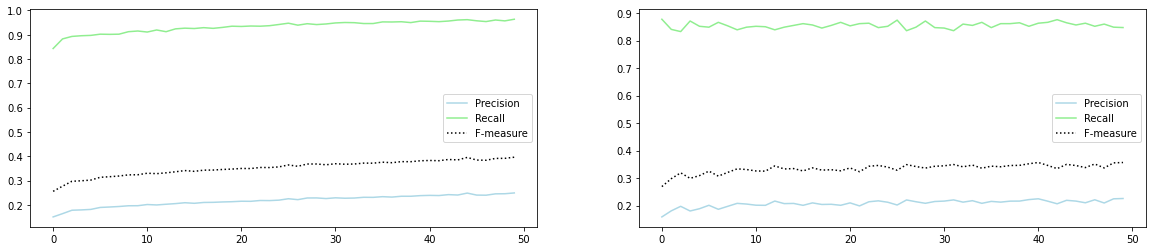

In [26]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
history = h
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history['tp'], history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history['tp'], history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history['tp'], history['fp'], history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history['val_tp'], history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history['val_tp'], history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history['val_tp'], history['val_fp'], history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

## Audio analysis and onset extraction

In [121]:
F_RATE = HOP/SR 
train_idx = np.array([ 0,  1,  3,  5,  6,  7, 8,  9, 10, 11, 12, 13, 15, 17, 18])
test_idx = np.array([ 2,  4, 14, 16])
test_idx = np.array([16])
test_audio_paths = ['datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index+1) for test_index in test_idx]
test_audios = [madmom.audio.signal.load_wave_file(path)[0] for path in test_audio_paths]
test_lengths = [len(test_audio)/SR for test_audio in test_audios]
test_onsets = [genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index+1), delimiter=',') for test_index in test_idx]
test_onset_vectors = [get_label_vector(test_onset, len(test_audio)/SR, HOP, SR) for test_audio, test_onset in zip(test_audios, test_onsets)]
print("Test recordings: ", test_idx+1)
print("Length of recordings: ", ["{:.1f} s".format(l) for l in test_lengths])
print([len(a)/HOP for a in test_audios])
print("Length of onset vectors: ", [len(v) for v in test_onset_vectors])
print("Number of annotated onsets: ", 
    [len(test_onset) for test_onset in test_onsets], 
    " = ", np.sum([len(test_onset) for test_onset in test_onsets])
)

Test recordings:  [17]
Length of recordings:  ['101.2 s']
[10124.843537414967]
Length of onset vectors:  [10125]
Number of annotated onsets:  [164]  =  164


In [122]:
full_audio = np.concatenate(test_audios)
cum_lengths = np.concatenate(([0.0], np.cumsum(test_lengths)))[:-1]
full_onsets = np.concatenate(
    [shift + onset for (shift, onset) in zip(cum_lengths, test_onsets)]
)
full_onset_vectors = np.concatenate(test_onset_vectors)

In [127]:
index_to_fold = {
    0: 2,
    1: 2,
    2: 1,
    3: 0,
    4: 1,
    5: 4,
    6: 0,
    7: 2,
    8: 3,
    9: 3,
    10: 0,
    11: 4,
    12: 4,
    13: 2,
    14: 1,
    15: 0,
    16: 1,
    17: 3,
    18: 3,
}

In [132]:
def get_test_peaks(activations, f_rate, threshold=0.5, kernel_size=5, n_pre=5, n_post=5):
    return madmom.features.onsets.peak_picking(
                                        activations=activations, 
                                        threshold=threshold, 
                                        smooth=kernel_size, 
                                        pre_avg=n_pre, 
                                        post_avg=n_post, 
                                        pre_max=n_pre, 
                                        post_max=n_post
    )[0].astype(np.float32)*f_rate

In [130]:
with open('results/cnn-training-220331/mean_by_fold.pickle', 'rb') as file_pi:
    means = pickle.load(file_pi)
with open('results/cnn-training-220331/std_by_fold.pickle', 'rb') as file_pi:
    stds = pickle.load(file_pi)

In [160]:
from analyze_detection import evaluate

TOL = 0.03

for test_index in np.arange(0,19):
    fold = index_to_fold[test_index]
    print("Test recording no ", test_index + 1, " which is in test set of fold ", fold)
    print("Loading data...")
    X_test = X[test_index]
    training_name = "finetune-dense-dropout"
    print("Loading model...")

    #Fold-independent
    model = tf.keras.models.load_model('results/cnn-training-220330/finetune-all-plus-dropout_model')
    model = tf.keras.models.load_model('results/cnn-training-220331/{}_fold_{}_model'.format(fold, training_name))
    print("Predicting...")
    test_model_out = model.predict((X_test-means[fold])/stds[fold])
    peaks = get_test_peaks(test_model_out, HOP/SR)
    print("Evaluating...")
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[test_index], peaks, tol_sec=TOL)
    print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
    print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))
    print("F-score: {:.1f} %".format( 200*CD/(2*CD+FP+FN)))
    #print("{}\t{}\t{}".format(CD,FN,FP))

    

Test recording no  1  which is in test set of fold  2
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 78.2 %
Recall: 98.4 %
F-score: 87.1 %
Test recording no  2  which is in test set of fold  2
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 71.8 %
Recall: 100.0 %
F-score: 83.6 %
Test recording no  3  which is in test set of fold  1
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 76.0 %
Recall: 93.4 %
F-score: 83.8 %
Test recording no  4  which is in test set of fold  0
Loading data...
Loading model...


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x13d3caa60>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Predicting...
Evaluating...
Precision: 90.9 %
Recall: 93.3 %
F-score: 92.1 %
Test recording no  5  which is in test set of fold  1
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 68.8 %
Recall: 94.1 %
F-score: 79.5 %
Test recording no  6  which is in test set of fold  4
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 93.6 %
Recall: 95.4 %
F-score: 94.5 %
Test recording no  7  which is in test set of fold  0
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 92.5 %
Recall: 84.7 %
F-score: 88.4 %
Test recording no  8  which is in test set of fold  2
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 79.8 %
Recall: 96.7 %
F-score: 87.4 %
Test recording no  9  which is in test set of fold  3
Loading data...
Loading model...
Predicting...
Evaluating...
Precision: 75.0 %
Recall: 92.6 %
F-score: 82.9 %
Test recording no  10  which is in test set of fold  3
Loading data...
Loading model...
Predicting...
E

In [128]:
def get_test_peaks(activations, f_rate, threshold=0.5, kernel_size=5, n_pre=5, n_post=5):
    return madmom.features.onsets.peak_picking(
                                        activations=activations, 
                                        threshold=threshold, 
                                        smooth=kernel_size, 
                                        pre_avg=n_pre, 
                                        post_avg=n_post, 
                                        pre_max=n_pre, 
                                        post_max=n_post
    )[0].astype(np.float32)*f_rate


[10.099999  10.26      10.4       10.5199995 10.679999  10.79
 10.94      11.05      11.23      11.79      12.44      12.57
 12.71      12.83      12.99      13.11      13.24      13.37
 13.54     ]


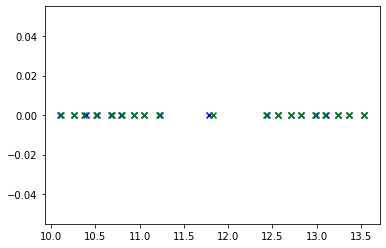

In [67]:
start_sec = 10
end_sec = 14
selected_peaks = test_peaks[np.intersect1d(
    np.where(test_peaks>=start_sec)[0],
    np.where(test_peaks<end_sec)[0])
]
selected_onsets = full_onsets[np.intersect1d(
    np.where(full_onsets>=start_sec)[0],
    np.where(full_onsets<end_sec)[0])
]
print(selected_peaks)
plt.scatter(selected_peaks, np.zeros_like(selected_peaks), marker='x', color='blue')
plt.scatter(selected_onsets, np.zeros_like(selected_onsets), marker='x', color='green')

In [126]:
from analyze_detection import evaluate

true = full_onsets
pred = test_peaks

TOL = 0.03
[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=TOL)
print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))
print("F-score: {:.1f} %".format( 200*CD/(2*CD+FP+FN)))

Precision: 61.0 %
Recall: 76.2 %
F-score: 67.8 %


In [82]:
start_sec = 30
dur_sec = 5

selected_audio = full_audio[start_sec*SR:(start_sec+dur_sec)*SR]
selected_onsets = full_onsets[np.intersect1d(
        np.where(full_onsets>=start_sec)[0], 
        np.where(full_onsets<start_sec+dur_sec)[0]
)]
selected_onehot = full_onset_vectors[int(start_sec/F_RATE):int((start_sec+dur_sec)/F_RATE)]
fig = plt.figure(figsize=(25,5))
if start_sec + dur_sec < len(full_audio)/SR:
    
    
    plt.plot(
        np.linspace(start_sec, start_sec+dur_sec, dur_sec*SR),
        selected_audio, 
        color="lightgray"
    )
    for i, onset in enumerate(selected_onehot):
        if onset==1:
            plt.scatter(start_sec + i*F_RATE/dur_sec, 0, color='green')
    plt.xlabel("Seconds")
    plt.show()

else:
    print("Cannot plot selected region, choose other start/dur values")

Cannot plot selected region, choose other start/dur values


<Figure size 1800x360 with 0 Axes>

In [138]:
for f in index_to_fold.values():
    print(f)

2
2
1
0
1
4
0
2
3
3
0
4
4
2
1
0
1
3
3


Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()